#NGSIM Exploratory Data Analysis Project#

## Main Imports ##

In [ ]:

import requests
import pandas as pd
import time
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


## Data Scraping Using REST API ##

In [ ]:
class NGSIMAnalyzer:
    def __init__(self, location: str = 'us-101', limit: int = 1000, max_rows: int = 5000):
        self.base_url = "https://data.transportation.gov/resource/8ect-6jqj.json"
        self.location = location
        self.limit = limit
        self.max_rows = max_rows
        self.data = pd.DataFrame()
        print(f"Initialized for location={location}, pulling up to {max_rows} rows.")

    def fetch_data(self):
        offset = 0
        all_data = []

        while offset < self.max_rows:
            url = f"{self.base_url}?location={self.location}&$limit={self.limit}&$offset={offset}"
            print(f"Fetching rows {offset} to {offset + self.limit}...")

            response = requests.get(url)
            if response.status_code != 200:
                print(f"Error: {response.status_code}")
                break

            batch = response.json()
            if not batch:
                print("No more data returned.")
                break

            all_data.extend(batch)
            offset += self.limit
            time.sleep(0.3)

        self.data = pd.DataFrame(all_data)
        print(f"Fetched total rows: {len(self.data)}")

    def save_to_csv(self, path="/content/ngsim_trajectory.csv"):
        if not self.data.empty:
            self.data.to_csv(path, index=False)
            print(f"Saved data to {path}")


In [ ]:
locations = ['us-101', 'i-80', 'peachtree']
row_limits = {'us-101': 100000, 'i-80': 100000, 'peachtree': 100000}

for loc in locations:
    analyzer = NGSIMAnalyzer(location=loc, max_rows=row_limits[loc])
    analyzer.fetch_data()
    analyzer.save_to_csv(f"/content/ngsim_{loc}.csv")


Initialized for location=us-101, pulling up to 100000 rows.
Fetching rows 0 to 1000...
Fetching rows 1000 to 2000...
Fetching rows 2000 to 3000...
Fetching rows 3000 to 4000...
Fetching rows 4000 to 5000...
Fetching rows 5000 to 6000...
Fetching rows 6000 to 7000...
Fetching rows 7000 to 8000...
Fetching rows 8000 to 9000...
Fetching rows 9000 to 10000...
Fetching rows 10000 to 11000...
Fetching rows 11000 to 12000...
Fetching rows 12000 to 13000...
Fetching rows 13000 to 14000...
Fetching rows 14000 to 15000...
Fetching rows 15000 to 16000...
Fetching rows 16000 to 17000...
Fetching rows 17000 to 18000...
Fetching rows 18000 to 19000...
Fetching rows 19000 to 20000...
Fetching rows 20000 to 21000...
Fetching rows 21000 to 22000...
Fetching rows 22000 to 23000...
Fetching rows 23000 to 24000...
Fetching rows 24000 to 25000...
Fetching rows 25000 to 26000...
Fetching rows 26000 to 27000...
Fetching rows 27000 to 28000...
Fetching rows 28000 to 29000...
Fetching rows 29000 to 30000...
Fe

## Data Cleaning & Summary ##

In [ ]:
def clean_data(df):
    # Drop mostly-empty or irrelevant columns
    df = df.drop(columns=[
        'o_zone', 'd_zone', 'int_id', 'section_id', 'direction',
        'movement', 'space_headway', 'time_headway'
    ], errors='ignore')

    # Convert all numeric columns
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Drop rows with missing key fields
    df.dropna(subset=['vehicle_id', 'global_time', 'local_x', 'local_y'], inplace=True)

    # Sort by vehicle and time
    df = df.sort_values(by=['vehicle_id', 'global_time']).reset_index(drop=True)

    return df


In [ ]:
def summarize_data(df, location_label, vehicle_class_map):
    print(f"\n📍 Summary for {location_label.upper()}")
    print(f"Total rows: {len(df)}")
    print(f"Unique vehicles: {df['vehicle_id'].nunique()}")
    print(f"Time range: {df['global_time'].min()} → {df['global_time'].max()}")
    print("Lane IDs:", sorted(df['lane_id'].dropna().astype(int).unique().tolist()))
    print("Vehicle Classes:")
    for k, v in df['v_class'].map(vehicle_class_map).value_counts().items():
        print(f" - {k}: {v}")

    print(f"Speed (v_vel) — mean: {df['v_vel'].mean():.2f}, max: {df['v_vel'].max():.2f}")





In [ ]:
# Google Drive Imports

from google.colab import drive
drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive
Mounted at /content/drive


In [ ]:
# This reads the paths for the files I saved and put in google Drive

df_us101 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ngsim_us-101.csv')
df_i80 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ngsim_i-80.csv')
df_peach = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ngsim_peachtree.csv')


In [ ]:
# Clean each file

df_us101 = clean_data(df_us101)
df_i80 = clean_data(df_i80)
df_peach = clean_data(df_peach)

vehicle_class_map = {
    1: "Motorcycle",
    2: "Passenger Vehicle",
    3: "Heavy Vehicle"
}

# Summarize each
summarize_data(df_us101, "us-101", vehicle_class_map)
summarize_data(df_i80, "i-80", vehicle_class_map)
summarize_data(df_peach, "peachtree", vehicle_class_map)



📍 Summary for US-101
Total rows: 100000
Unique vehicles: 2847
Time range: 1118846982800 → 1118849749900
Lane IDs: [1, 2, 3, 4, 5, 6, 7, 8]
Vehicle Classes:
 - Passenger Vehicle: 97412
 - Heavy Vehicle: 2106
 - Motorcycle: 482
Speed (v_vel) — mean: 30.00, max: 95.30

📍 Summary for I-80
Total rows: 100000
Unique vehicles: 1142
Time range: 1113433161100 → 1113438734000
Lane IDs: [1, 2, 3, 4, 5, 6, 7]
Vehicle Classes:
 - Passenger Vehicle: 95940
 - Heavy Vehicle: 3393
 - Motorcycle: 667
Speed (v_vel) — mean: 14.26, max: 95.30

📍 Summary for PEACHTREE
Total rows: 100000
Unique vehicles: 1515
Time range: 1163019200 → 1164062800
Lane IDs: [0, 1, 2, 3, 4, 11, 1061, 9999]
Vehicle Classes:
 - Passenger Vehicle: 97748
 - Heavy Vehicle: 2121
 - Motorcycle: 131
Speed (v_vel) — mean: 15.28, max: 55.82


## Data Visualizations ##

In [ ]:


def plot_vehicle_trajectories(df, location_label, vehicle_ids=None, color_by='lane_id', max_vehicles=5):
    """
    Plot trajectories for selected vehicles using local_x and local_y.
    """
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df['local_x'], df['local_y'],
                          c=df[color_by], cmap='viridis', s=10)

    plt.colorbar(scatter, label=color_by)
    plt.title(f'Vehicle Trajectories – {location_label.upper()}')
    plt.xlabel("Local X (meters)")
    plt.ylabel("Local Y (meters)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

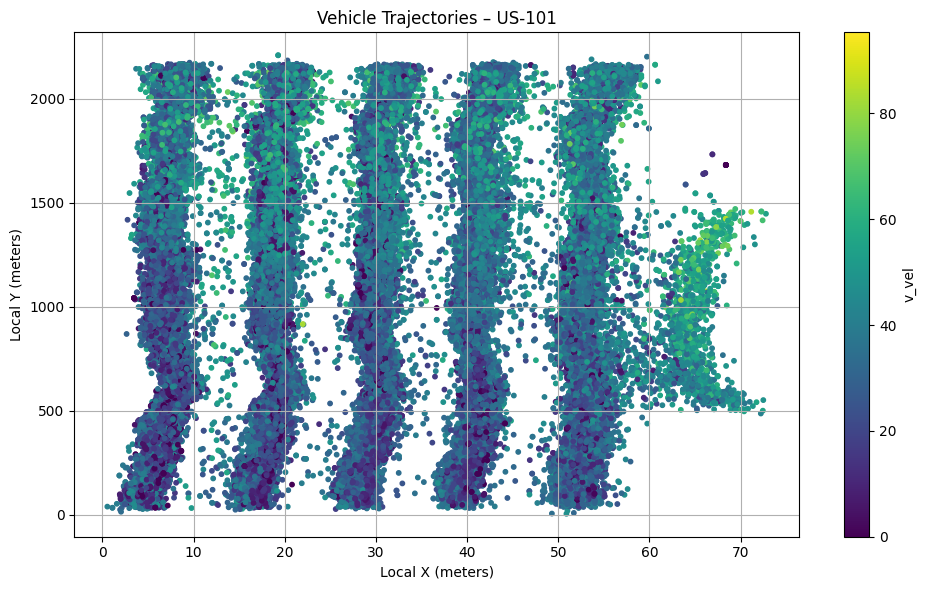

In [ ]:
plot_vehicle_trajectories(df_us101, location_label='us-101', color_by='v_vel')


### US-101 Vehicle Velocity Analysis ###

5 clearly defined and tightly packed lanes with a high traffic on-ramp/off-ramp on the right. Wide range of vehicle speeds with similar speeds across each lane and high speeds on the ramp. Consistent spacing between vehicles.

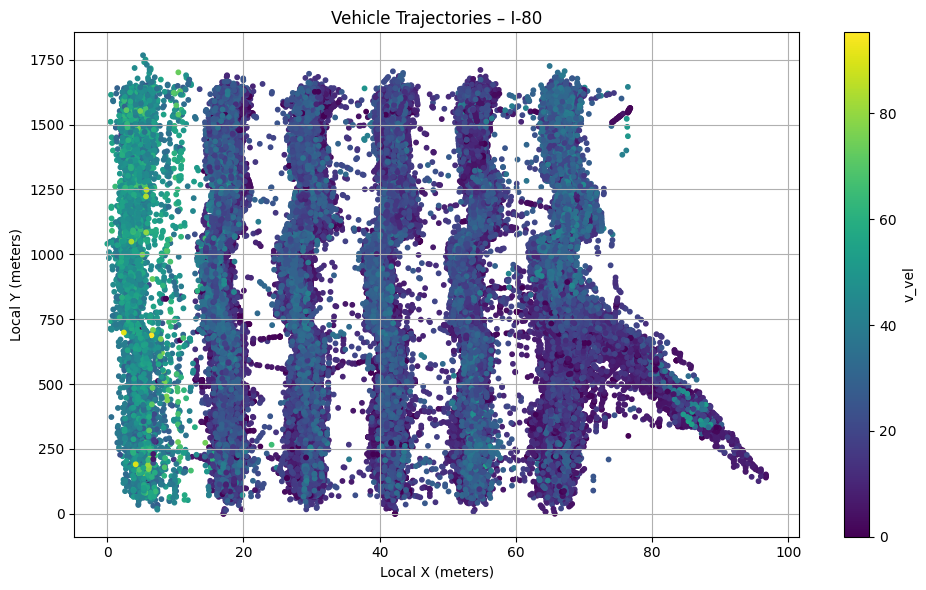

In [ ]:
plot_vehicle_trajectories(df_i80, location_label='i-80', color_by='v_vel')

### I-8O Vehicle Velocity Analysis ###

High density in the right most lanes indicating high traffic in merging lane. High speed in the left-most lane with slightly lower density than other lanes indicating possible express lane. Generally slower than US-101 indicating higher traffic/congestion.

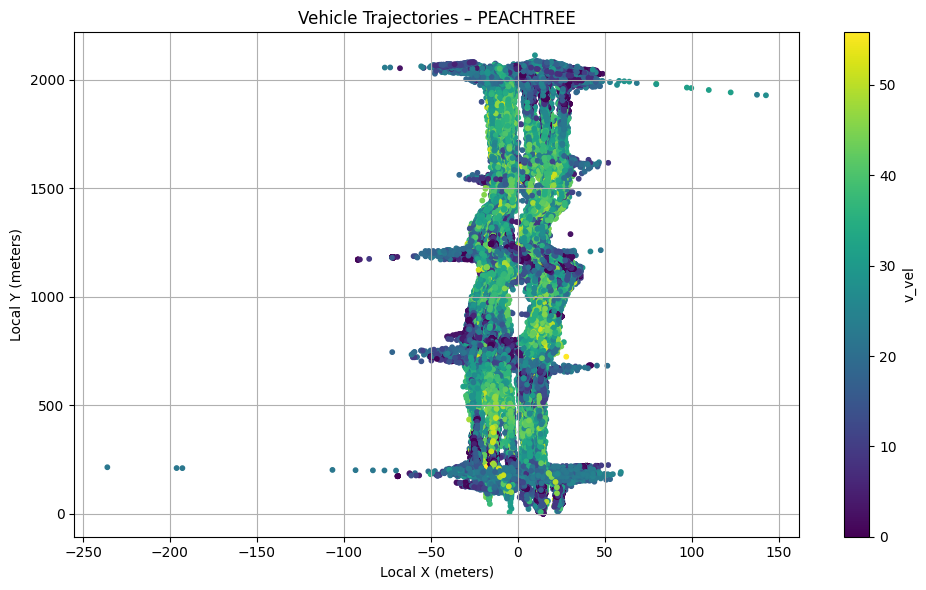

In [ ]:
plot_vehicle_trajectories(df_peach, location_label='peachtree', color_by='v_vel')

### PEACHTREE Vehicle Velocity Analysis ###

Narrow lanes with horizontal spread indicating 1-2 central lanes. Much lower top end speed than the other two roads indicating lower speed limit, stop-and-go traffic and more congestion, consistent with urban traffic patterns. Horizontal spread likely indicates turns off the road due to intersections.

In [ ]:


def plot_speed_histograms_all_locations(df_list, labels, vehicle_class_map):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=False)
    all_lines = []  # For collecting handles for a shared legend
    all_labels = []

    for ax, df, label in zip(axes, df_list, labels):
        df['vehicle_type'] = df['v_class'].map(vehicle_class_map)

        for vt in df['vehicle_type'].unique():
            line = sns.histplot(
                df[df['vehicle_type'] == vt]['v_vel'],
                kde=True,
                stat='density',
                bins=30,
                element='step',
                fill=False,
                label=vt,
                ax=ax
            )
        ax.set_title(f"{label}")
        ax.set_xlabel("Speed (m/s)")
        ax.grid(True)

    axes[0].set_ylabel("Density")

    # Shared legend from last axis
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
    handles, labels,
    title="Vehicle Type",
    loc="center left",
    bbox_to_anchor=(0.85, 0.5)  # Right side, centered vertically
    )

    plt.suptitle("Speed Distributions by Vehicle Type Across Locations", fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])
    plt.show()


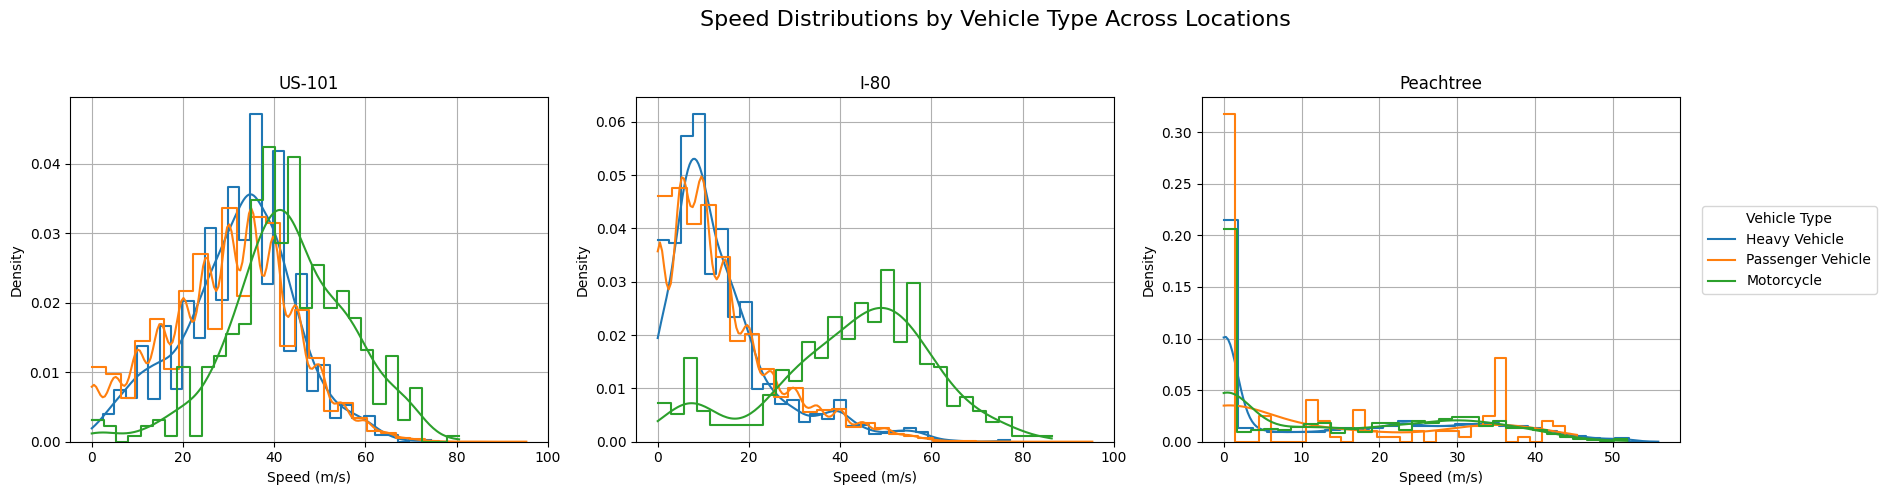

In [ ]:
plot_speed_histograms_all_locations(
    [df_us101, df_i80, df_peach],
    ["US-101", "I-80", "Peachtree"],
    vehicle_class_map
)


### Speed Distribution Comparative Analysis ###

US-101 and I-80 have high density clustering around lower-mid range speeds for cars and heavy vehicles with motorcycles generally being at higher speeds. On the I-80 there is a large disrecepancy in motorcycle speed compared to other vehicles indicating possibly indicating prevalence of lane splitting. This is further supported by idling speed of 0-10 m/s being represented almost entirely by cars and heavy vehicles implying that motor cycles are avoiding congestion via lane splitting. On Peachtree, all vehicles have similar speeds with a spike at 0 m/s indicating frequent stopping/idling.

In [ ]:
def plot_acceleration_histograms_all_locations(df_list, labels, vehicle_class_map):

    fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=False)

    for ax, df, label in zip(axes, df_list, labels):
        df['vehicle_type'] = df['v_class'].map(vehicle_class_map)

        for vt in df['vehicle_type'].unique():
            sns.histplot(
                df[df['vehicle_type'] == vt]['v_acc'],
                kde=True,
                stat='density',
                bins=30,
                element='step',
                fill=False,
                label=vt,
                ax=ax
            )

        ax.set_title(f"{label}")
        ax.set_xlabel("Acceleration (m/s²)")
        ax.grid(True)

    axes[0].set_ylabel("Density")
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title="Vehicle Type", loc="center left", bbox_to_anchor=(0.85, 0.5))
    plt.suptitle("Acceleration Distributions by Vehicle Type Across Locations", fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])
    plt.show()


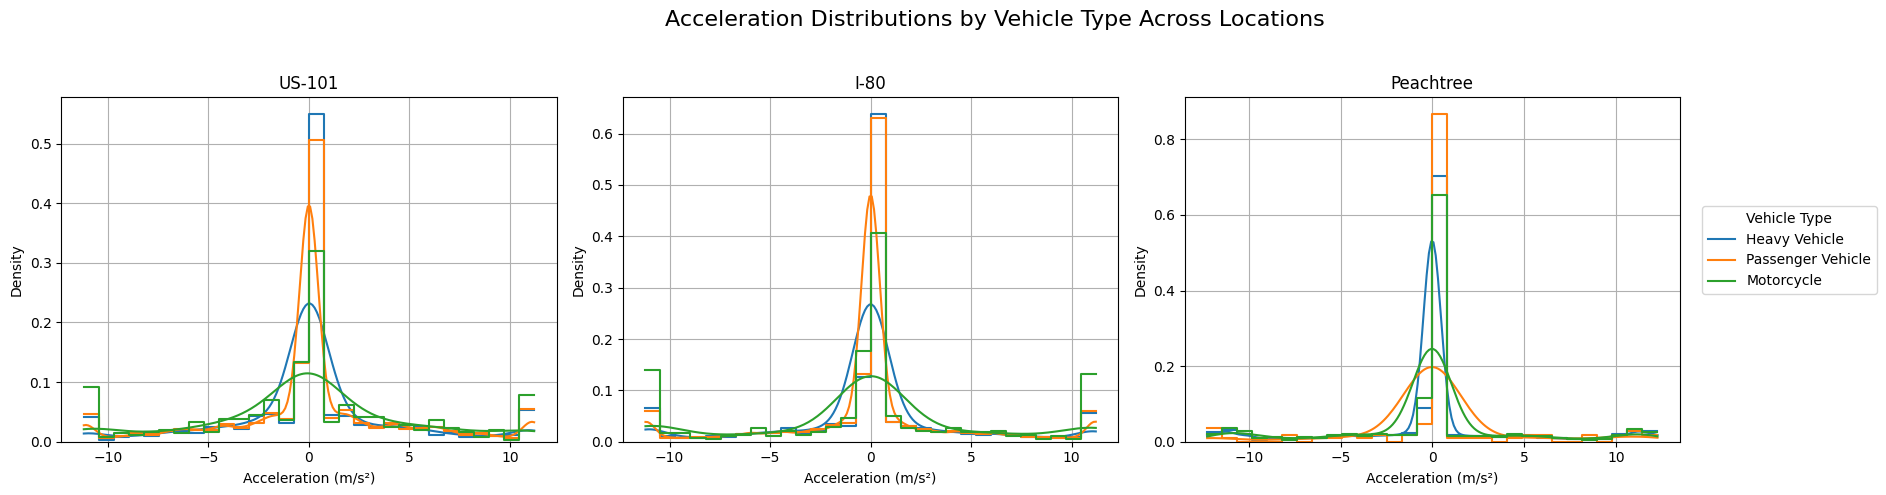

In [ ]:
plot_acceleration_histograms_all_locations(
    [df_us101, df_i80, df_peach],
    ["US-101", "I-80", "Peachtree"],
    vehicle_class_map
)


### Speed Distribution Comparative Analysis ###

All 3 roads have a high density around 0 m/s indicating for US101 & I-80 consistent cruising speeds and for Peachtree, likely consistent stopping and waiting due to traffic signals and/or congestion. Heavy vehicles seem to have the narrowest distribution, passenger cars are moderate and motorcycles have the widest tails. This highlights the difference in manoeverability and driving style between heavy vehicles (gentle), passenger vehicles (moderate) and motorcycles (agile).

In [ ]:
def plot_lane_usage_bar_all_locations(df_list, labels, vehicle_class_map):

    fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

    for ax, df, label in zip(axes, df_list, labels):
        df = df[df['lane_id'].notna() & (df['lane_id'] < 100)].copy()
        df['vehicle_type'] = df['v_class'].map(vehicle_class_map)

        lane_counts = (
            df.groupby(['vehicle_type', 'lane_id'])
            .size()
            .groupby(level=0)
            .transform(lambda x: x / x.sum())  # Normalize within vehicle type
            .reset_index(name='proportion')
        )

        pivot = lane_counts.pivot(index='lane_id', columns='vehicle_type', values='proportion').fillna(0)
        pivot.plot(kind='bar', stacked=False, ax=ax)

        ax.set_title(label)
        ax.set_xlabel("Lane ID")
        ax.set_ylabel("Vehicle Type Proportion")
        ax.grid(True)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title="Vehicle Type", loc="center left", bbox_to_anchor=(0.85, 0.5))
    plt.suptitle("Normalized Lane Usage by Vehicle Type Across Locations", fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])
    plt.show()


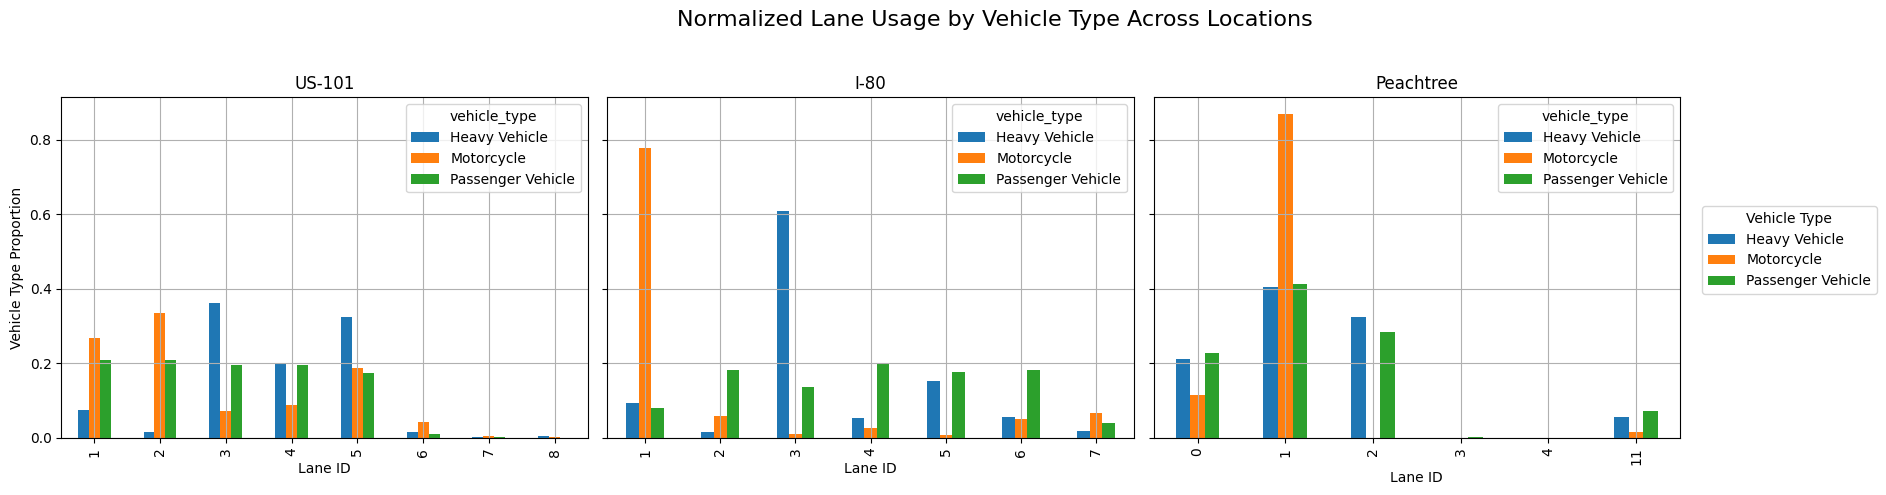

In [ ]:
plot_lane_usage_bar_all_locations(
    [df_us101, df_i80, df_peach],
    ["US-101", "I-80", "Peachtree"],
    vehicle_class_map
)


### Lane Usage Analysis ###

Motorcycles seem to cluster in the left-most lanes which are generally considered faster lanes and in some cases express lanes. Meanwhile heavy vehicles largely stay in right-most lanes likely due to regulations and required driving style. Passenger vehicles have a more moderate, relatively even distribution accross all lanes. In general, passenger vehicles also seem to decrease frequency in lanes frequented by heavy vehicles. On the I-80 heavy vehicles cluster heavily in lane 3 possibly indicating a designated truck lane. Motorcycles also seem to dominate lane 1 in Peachtree indicating that they do not often turn at this intersection. It would be interesting to know why that is.

## Random Forest Model ##

### Data Preparation ###

In [ ]:
from sklearn.model_selection import train_test_split

def prepare_trajectory_data(df):
    df = df.sort_values(by=['vehicle_id', 'frame_id']).copy()
    df['next_local_x'] = df.groupby('vehicle_id')['local_x'].shift(-1)
    df['next_local_y'] = df.groupby('vehicle_id')['local_y'].shift(-1)

    desired_features = [
        'local_x', 'local_y', 'v_vel', 'v_acc', 'lane_id',
        'v_length', 'v_width', 'space_headway', 'time_headway',
        'direction', 'movement'
    ]

    # Filter to only available and non-null columns
    available_features = [f for f in desired_features if f in df.columns and df[f].notna().any()]

    # Create combined DataFrame
    all_features = available_features + ['next_local_x', 'next_local_y']
    combined = df[all_features].dropna()

    X_clean = combined[available_features]
    y_clean = combined[['next_local_x', 'next_local_y']]

    return train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)


### Training ###

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

def train_random_forest_model(X_train, y_train, X_test, y_test):
    model = MultiOutputRegressor(
        RandomForestRegressor(
            n_estimators=100,
            max_depth=15,
            random_state=42,
            n_jobs=-1
        )
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mse  = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)

    return model, preds, rmse


### Predictions Plot ###

In [ ]:


def plot_predictions_overlay(y_tests, y_preds, titles):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    for ax, y_true, y_pred, title in zip(axes, y_tests, y_preds, titles):
        ax.scatter(y_true['next_local_x'], y_true['next_local_y'], c='blue', s=5, label='True', alpha=0.4)
        ax.scatter(y_pred[:, 0], y_pred[:, 1], c='orange', s=5, label='Predicted', alpha=0.4)
        ax.set_title(title)
        ax.set_xlabel("Local X")
        ax.set_ylabel("Local Y")
        ax.grid(True)

    # Only show one legend, outside the last plot
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.12, 0.5), title="Legend")

    plt.suptitle("Random Forest Predicted vs Actual Next Positions", fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.95, 0.95])
    plt.show()


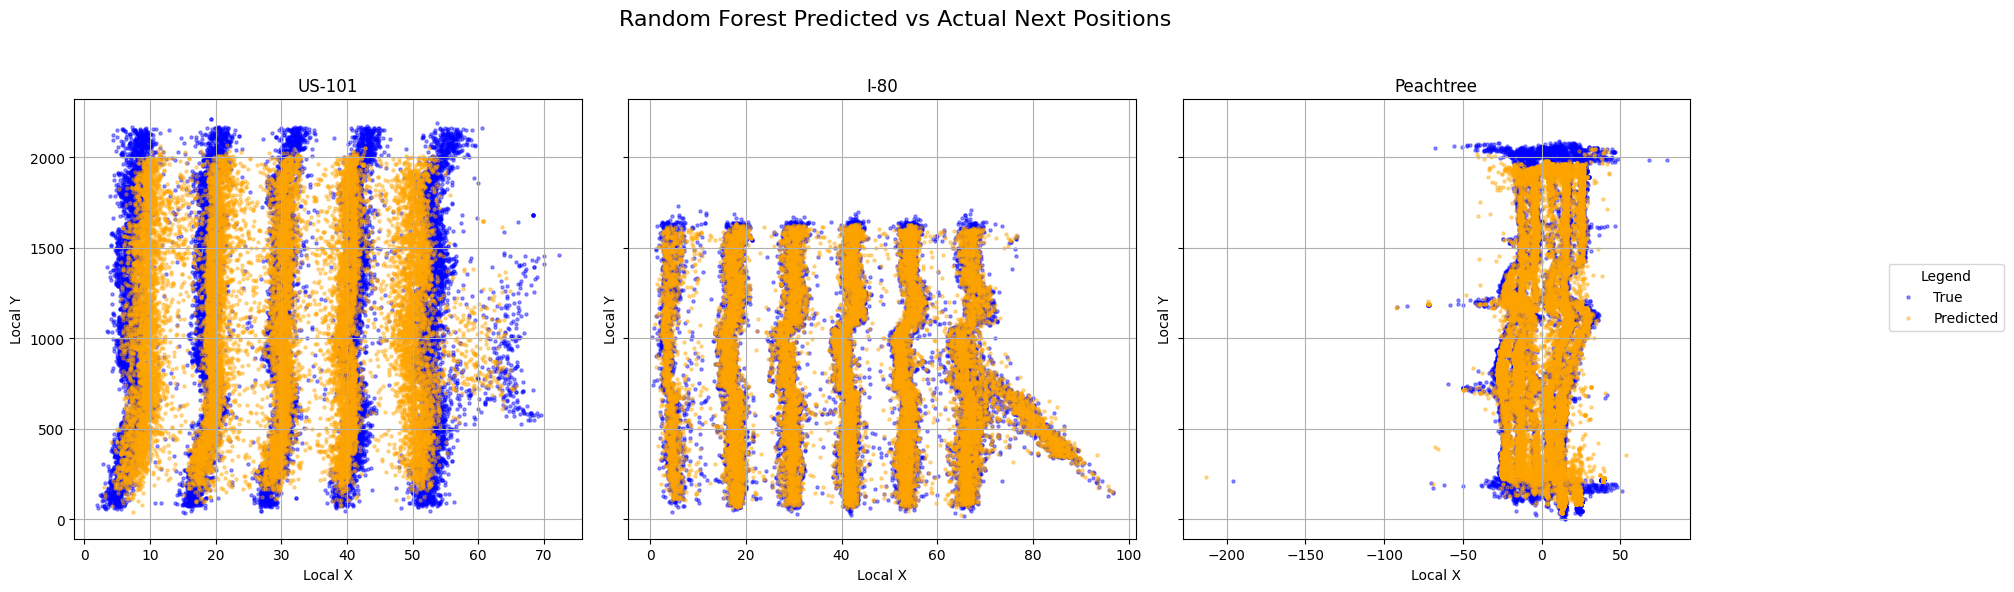

RMSE US-101: 220.79
RMSE I-80: 58.36
RMSE Peachtree: 155.51


In [ ]:
# Prep data
X_train_us, X_test_us, y_train_us, y_test_us       = prepare_trajectory_data(df_us101)
X_train_i80, X_test_i80, y_train_i80, y_test_i80   = prepare_trajectory_data(df_i80)
X_train_peach, X_test_peach, y_train_peach, y_test_peach = prepare_trajectory_data(df_peach)

# Train + evaluate
model_us,    preds_us,    rmse_us    = train_random_forest_model(X_train_us,  y_train_us,  X_test_us,  y_test_us)
model_i80,   preds_i80,   rmse_i80   = train_random_forest_model(X_train_i80, y_train_i80, X_test_i80, y_test_i80)
model_peach, preds_peach, rmse_peach = train_random_forest_model(X_train_peach, y_train_peach, X_test_peach, y_test_peach)

# Plot
plot_predictions_overlay(
    [y_test_us, y_test_i80, y_test_peach],
    [preds_us,  preds_i80,  preds_peach],
    ["US-101", "I-80", "Peachtree"]
)

# Optionally print MSEs
print(f"RMSE US-101: {rmse_us:.2f}")
print(f"RMSE I-80: {rmse_i80:.2f}")
print(f"RMSE Peachtree: {rmse_peach:.2f}")


### Random Forest Vehicle Trajectory Analysis ###

The model is able to grasp the general shape of the traffic flow and macro vehicle patterns but it struggles to hone in on specific vehicle movement frame by frame. MSE seems to have a high penalty for large errors, especially from outliers like multi lane-switching and exiting the highway which is why the model RMSE is relatively high.

## ALSTM Model ##

### Imports & Initialization ###

In [ ]:
# 1) IMPORTS & PARAMETERS

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Softmax, Lambda,
    Bidirectional, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Hyperparameters
TIMESTEPS   = 10     # lookback window
BATCH_SIZE  = 512
EPOCHS      = 30
PATIENCE    = 5      # for early stopping
FEATURES    = [
    'local_x','local_y',
    'v_vel','v_acc',
    'lane_id','v_length','v_width'
]

### Feature Engineering ###

In [ ]:
# 2) FEATURE SCALING
# Standardize each location separately (fit on full df for simplicity)
scaler_us      = StandardScaler()
df_us101_scaled = df_us101.copy()
df_us101_scaled[FEATURES] = scaler_us.fit_transform(df_us101[FEATURES])

scaler_i80     = StandardScaler()
df_i80_scaled   = df_i80.copy()
df_i80_scaled[FEATURES]  = scaler_i80.fit_transform(df_i80[FEATURES])

scaler_peach   = StandardScaler()
df_peach_scaled = df_peach.copy()
df_peach_scaled[FEATURES] = scaler_peach.fit_transform(df_peach[FEATURES])

### Data Preparation & Splitting ###

In [ ]:
# 3) SEQUENCE DATA PREPARATION
def prepare_lstm_data(df, features, timesteps=TIMESTEPS, test_size=0.2):
    df = df.sort_values(by=['vehicle_id','frame_id']).reset_index(drop=True)
    seqs, targets = [], []
    arr = df[features].values
    vids = df['vehicle_id'].values

    for i in range(len(df) - timesteps):
        # ensure the window and its target belong to the same vehicle
        if vids[i] == vids[i + timesteps]:
            seqs.append(arr[i:i+timesteps])
            targets.append(arr[i+timesteps, :2])  # next_local_x, next_local_y

    X = np.stack(seqs)       # (n_samples, timesteps, n_features)
    y = np.stack(targets)    # (n_samples, 2)
    return train_test_split(X, y, test_size=test_size, random_state=42)

# Prepare train/test for each location
X_tr_us, X_te_us, y_tr_us, y_te_us     = prepare_lstm_data(df_us101_scaled, FEATURES)
X_tr_i80, X_te_i80, y_tr_i80, y_te_i80 = prepare_lstm_data(df_i80_scaled,   FEATURES)
X_tr_pe, X_te_pe, y_tr_pe, y_te_pe     = prepare_lstm_data(df_peach_scaled, FEATURES)

### Model Instantiation ###

In [ ]:
# 4) BUILD DEEP ALSTM MODEL
def build_alstm(timesteps, n_features):
    inp = Input(shape=(timesteps, n_features))

    # stacked, bidirectional LSTM layers
    x = Bidirectional(LSTM(128, return_sequences=True))(inp)
    x = Dropout(0.2)(x)
    x = LSTM(64, return_sequences=True)(x)

    # attention mechanism
    score = Dense(1)(x)                        # (batch, t, 1)
    weights = Softmax(axis=1)(score)           # along time axis
    context = Lambda(lambda z: tf.reduce_sum(z[0]*z[1], axis=1))([x, weights])

    # final dense head
    h = Dense(64, activation='relu')(context)
    out = Dense(2, name='next_position')(h)    # predict (next_x, next_y)

    model = Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )
    return model

# Instantiate models
model_us  = build_alstm(TIMESTEPS, len(FEATURES))
model_i80 = build_alstm(TIMESTEPS, len(FEATURES))
model_pe  = build_alstm(TIMESTEPS, len(FEATURES))

# Early stopping callback
es = EarlyStopping(
    monitor='val_rmse', patience=PATIENCE, restore_best_weights=True
)


### Training ###

In [ ]:
# 5) TRAINING
history_us = model_us.fit(
    X_tr_us, y_tr_us,
    validation_data=(X_te_us, y_te_us),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es],
    verbose=2
)

history_i80 = model_i80.fit(
    X_tr_i80, y_tr_i80,
    validation_data=(X_te_i80, y_te_i80),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es],
    verbose=2
)

history_pe = model_pe.fit(
    X_tr_pe, y_tr_pe,
    validation_data=(X_te_pe, y_te_pe),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es],
    verbose=2
)


Epoch 1/30
113/113 - 39s - 344ms/step - loss: 0.3737 - rmse: 0.6113 - val_loss: 0.2798 - val_rmse: 0.5289
Epoch 2/30
113/113 - 39s - 349ms/step - loss: 0.2609 - rmse: 0.5107 - val_loss: 0.2587 - val_rmse: 0.5086
Epoch 3/30
113/113 - 41s - 360ms/step - loss: 0.2504 - rmse: 0.5004 - val_loss: 0.2545 - val_rmse: 0.5045
Epoch 4/30
113/113 - 29s - 260ms/step - loss: 0.2459 - rmse: 0.4959 - val_loss: 0.2538 - val_rmse: 0.5038
Epoch 5/30
113/113 - 30s - 263ms/step - loss: 0.2434 - rmse: 0.4934 - val_loss: 0.2499 - val_rmse: 0.4999
Epoch 6/30
113/113 - 31s - 275ms/step - loss: 0.2404 - rmse: 0.4903 - val_loss: 0.2534 - val_rmse: 0.5034
Epoch 7/30
113/113 - 32s - 287ms/step - loss: 0.2390 - rmse: 0.4889 - val_loss: 0.2478 - val_rmse: 0.4978
Epoch 8/30
113/113 - 30s - 264ms/step - loss: 0.2372 - rmse: 0.4870 - val_loss: 0.2459 - val_rmse: 0.4958
Epoch 9/30
113/113 - 41s - 364ms/step - loss: 0.2358 - rmse: 0.4856 - val_loss: 0.2457 - val_rmse: 0.4957
Epoch 10/30
113/113 - 41s - 364ms/step - loss:

### Evaluation & Plotting ###

In [ ]:
# 6) EVALUATE FINAL RMSE

rmse_us  = model_us.evaluate(X_te_us, y_te_us, verbose=0)[1]
rmse_i80 = model_i80.evaluate(X_te_i80, y_te_i80, verbose=0)[1]
rmse_pe = model_pe.evaluate(X_te_pe, y_te_pe, verbose=0)[1]

print(f"\n► US-101 ALSTM RMSE:     {rmse_us: .2f} m")
print(f"► I-80 ALSTM RMSE:       {rmse_i80: .2f} m")
print(f"► Peachtree ALSTM RMSE:  {rmse_pe: .2f} m\n")



► US-101 ALSTM RMSE:      0.49 m
► I-80 ALSTM RMSE:        0.14 m
► Peachtree ALSTM RMSE:   0.30 m



In [ ]:
# 7) PLOTTING PREDICTIONS VS ACTUAL (side-by-side)

def plot_predictions_overlay(y_tests, models, titles):
    # y_tests: list of true (next_x,next_y) arrays
    # models:   list of trained models to predict on X_test
    fig, axes = plt.subplots(1, 3, figsize=(18,6), sharey=True)
    for ax, (X_te, y_te, model, title) in zip(
        axes,
        [(X_te_us, y_te_us, model_us, titles[0]),
         (X_te_i80, y_te_i80, model_i80, titles[1]),
         (X_te_pe, y_te_pe, model_pe, titles[2])]
    ):
        preds = model.predict(X_te, verbose=0)
        ax.scatter(y_te[:,0], y_te[:,1],
                   c='blue', s=5, alpha=0.4, label='True')
        ax.scatter(preds[:,0], preds[:,1],
                   c='orange', s=5, alpha=0.4, label='Predicted')
        ax.set_title(title)
        ax.set_xlabel("Local X")
        ax.set_ylabel("Local Y")
        ax.grid(True)

    # Single legend on the right
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', title='Legend')
    fig.suptitle("ALSTM Predicted vs Actual Next Positions", fontsize=16)
    fig.tight_layout(rect=[0,0,0.95,0.95])
    plt.show()


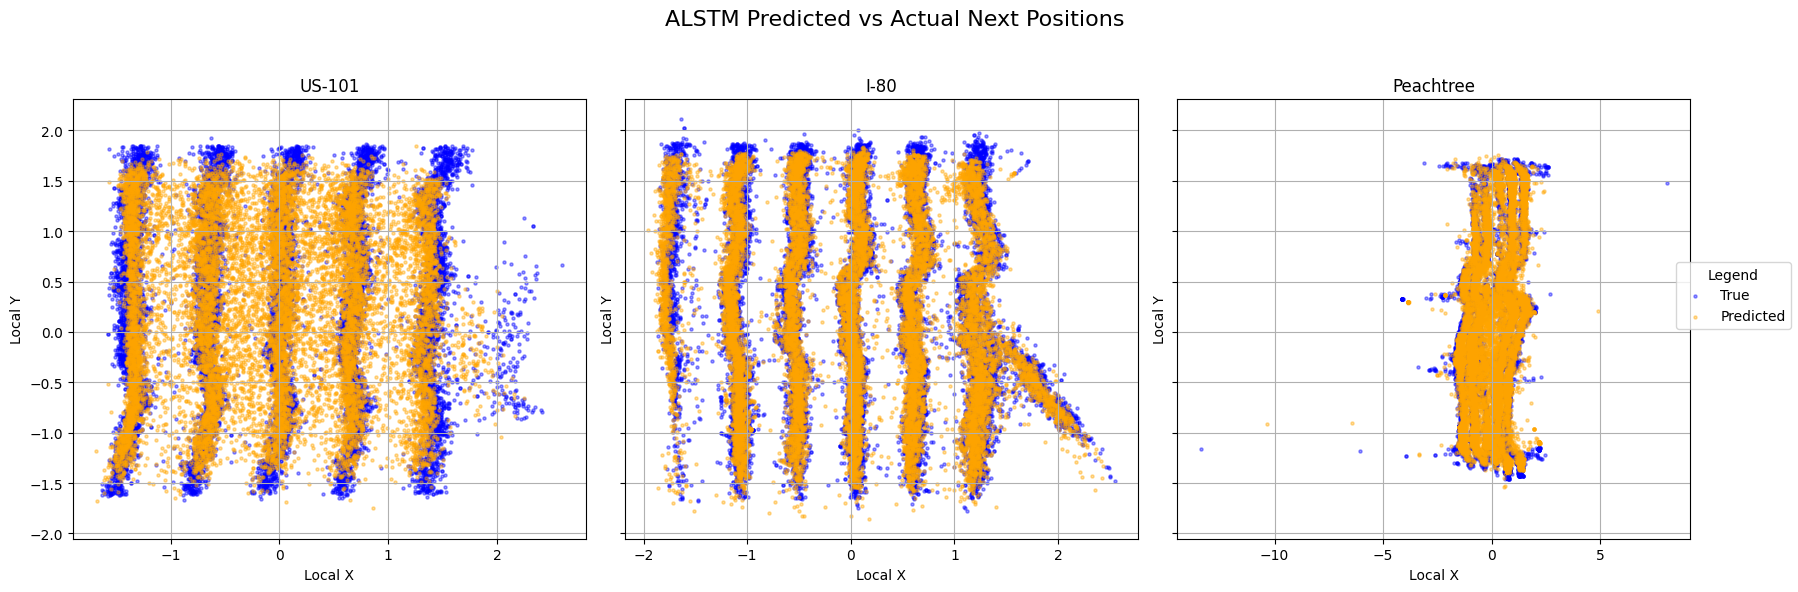

In [ ]:

# Plot
plot_predictions_overlay(
    [y_te_us, y_te_i80, y_te_pe],
    [model_us, model_i80, model_pe],
    ["US-101", "I-80", "Peachtree"]
)


### ALSTM Trajectory Analysis ###

The ALSTM seems to perform much better than Random Forest did with an RMSE of 0.14 - 0.49 across the 3 roads meaning the predictions were off by less than half a meter per frame. The model still seems to have difficulty mapping onto the merging/exiting right-most lane of US-101. These results are still a farcry from more robust models such as Altche, Fortelle (2018) which can predict vehicle trajectories within 100cm up to 10s in the future.